In [1]:
import numpy as np
from numpy.lib.stride_tricks import as_strided
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
import scipy.io as sio
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from scipy import ndimage, misc
import time
import os    
import random
os.environ['KMP_DUPLICATE_LIB_OK']='True'
#%% Check GPU availability
print(f"Pytorch Version: {torch.__version__}")
print("GPU is", "available" if torch.cuda.is_available() else "NOT AVAILABLE")

# print(torch.cuda.get_device_name(torch.cuda.current_device()))   
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#%% set seed

manualSeed = 1234
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(manualSeed)
torch.cuda.manual_seed(manualSeed)
torch.cuda.manual_seed_all(manualSeed)
np.random.seed(manualSeed)
random.seed(manualSeed)


Pytorch Version: 2.9.0+cu128
GPU is available


/tmp/ipykernel_94927/221161479.py:9: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  from scipy import ndimage, misc


[Iteration: 0] [obj: ---] [obj_fea: 7.2232] [vol: 0.5000]


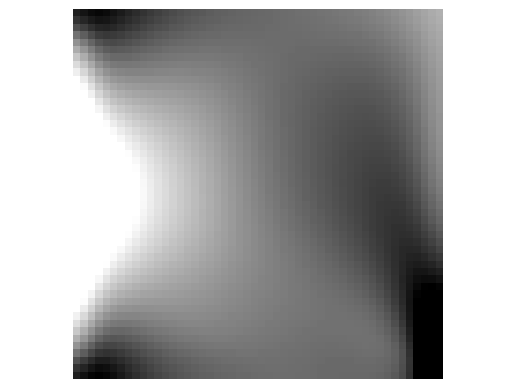

[Iteration: 1] [time: 17.76 sec] [obj: 149.3811] [obj_fea: 7.2232] [vol: 0.50]


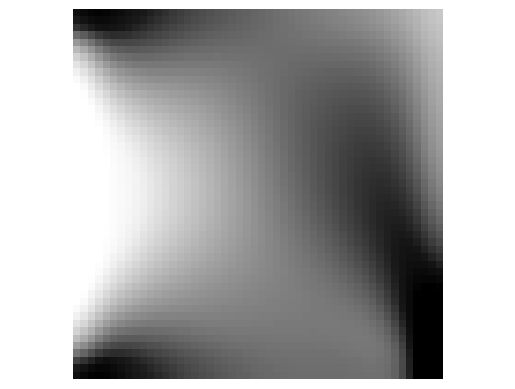

[Iteration: 2] [time: 19.12 sec] [obj: 115.5122] [obj_fea: 6.5602] [vol: 0.50]


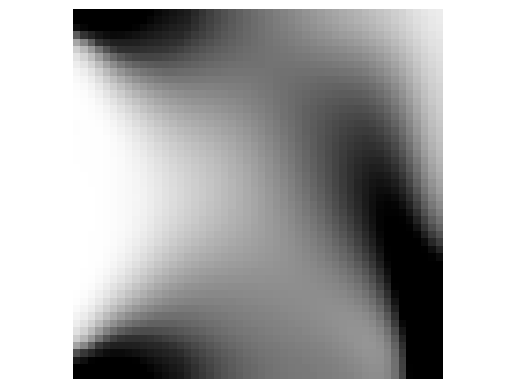

[Iteration: 3] [time: 18.78 sec] [obj: 83.2619] [obj_fea: 6.1430] [vol: 0.50]


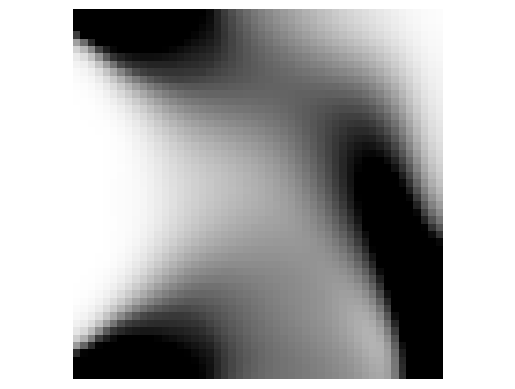

[Iteration: 4] [time: 20.62 sec] [obj: 75.7599] [obj_fea: 6.4041] [vol: 0.50]


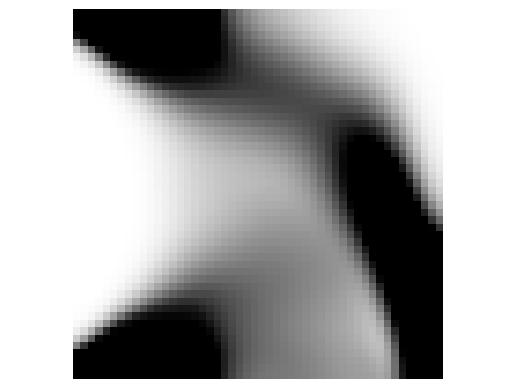

[Iteration: 5] [time: 20.76 sec] [obj: 70.7399] [obj_fea: 8.7228] [vol: 0.50]


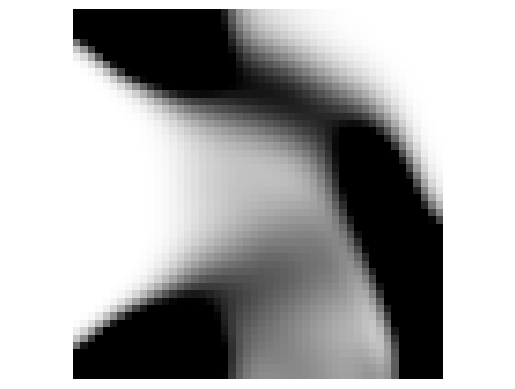

[Iteration: 6] [time: 26.87 sec] [obj: 66.2390] [obj_fea: 18.0442] [vol: 0.50]


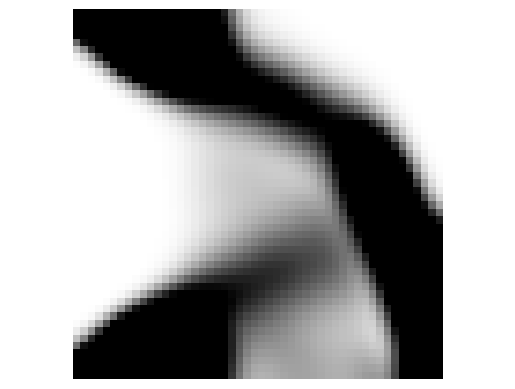

[Iteration: 7] [time: 26.73 sec] [obj: 57.0261] [obj_fea: 36.0228] [vol: 0.50]


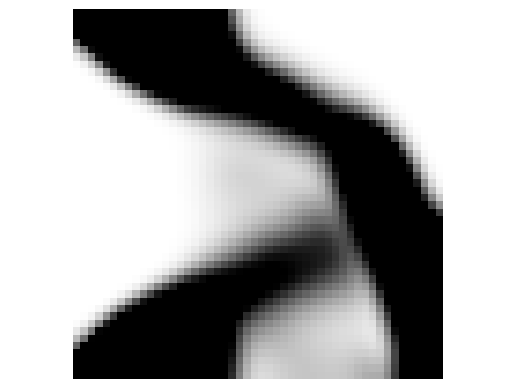

[Iteration: 8] [time: 23.75 sec] [obj: 51.8000] [obj_fea: 42.4313] [vol: 0.50]


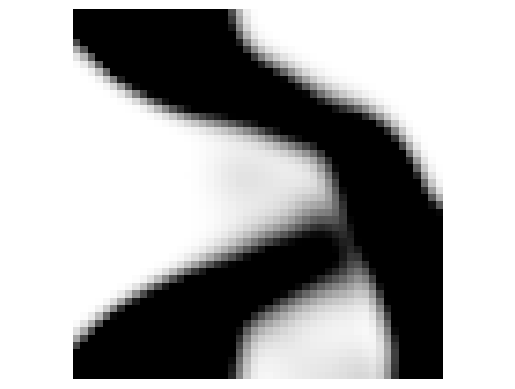

[Iteration: 9] [time: 23.52 sec] [obj: 44.2801] [obj_fea: 24.3509] [vol: 0.50]


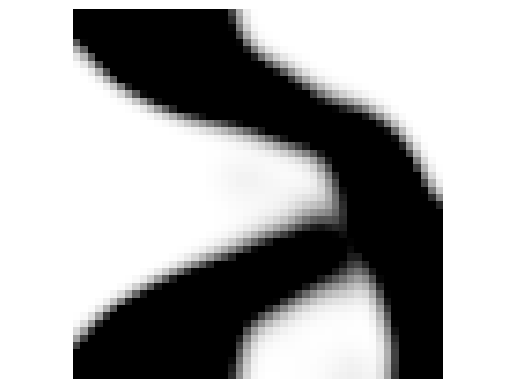

[Iteration: 10] [time: 21.17 sec] [obj: 40.0627] [obj_fea: 8.6275] [vol: 0.50]


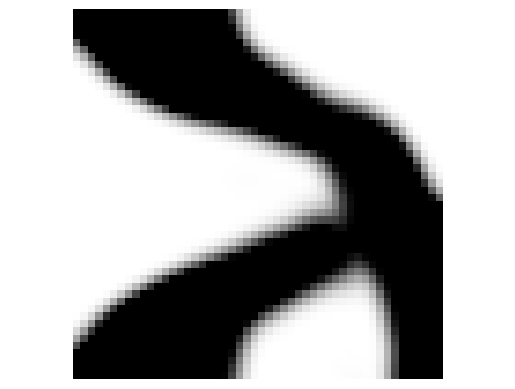

[Iteration: 11] [time: 20.82 sec] [obj: 41.1570] [obj_fea: 4.0169] [vol: 0.50]


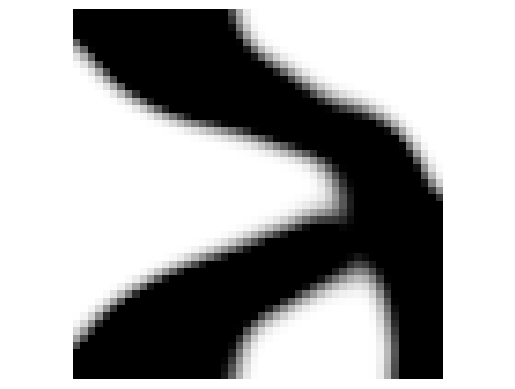

[Iteration: 12] [time: 22.18 sec] [obj: 40.8154] [obj_fea: 2.7806] [vol: 0.50]


KeyboardInterrupt: 

In [3]:
 

#%% Pooling operation for density-interpolation scheme
def pool2d(A, kernel_size, stride, padding=0, pool_mode='max'):
    # Padding
   A = np.pad(A, padding, mode='constant')

    # Window view of A
   output_shape = ((A.shape[0] - kernel_size) // stride + 1,
                    (A.shape[1] - kernel_size) // stride + 1)
    
   shape_w = (output_shape[0], output_shape[1], kernel_size, kernel_size)
   strides_w = (stride*A.strides[0], stride*A.strides[1], A.strides[0], A.strides[1])
    
   A_w = as_strided(A, shape_w, strides_w)

   # Return the result of pooling
   if pool_mode == 'max':
       return A_w.max(axis=(2, 3))
   elif pool_mode == 'avg':
       return A_w.mean(axis=(2, 3))

#%% Optimality Criterion
def oc(nelx,nely,x,volfrac,dc,dv,g):
	l1=0
	l2=1e9
	move=0.2
	# reshape to perform vector operations
	xnew=np.zeros(nelx*nely)
	while (l2-l1)/(l1+l2)>1e-3:
		lmid=0.5*(l2+l1)
		xnew[:]= np.maximum(0.0,np.maximum(x-move,np.minimum(1.0,np.minimum(x+move,x*np.sqrt(-dc/dv/lmid)))))
		gt=g+np.sum((dv*(xnew-x)))
		if gt>0 :
			l1=lmid
		else:
			l2=lmid
	return (xnew,gt)
#%% Energy-based PINN neural network
class Net(nn.Module):

    def __init__(self, n_input, n_output, n_layer, n_nodes):
        super(Net, self).__init__()
        self.n_layer = n_layer
        self.Input = nn.Linear(n_input, n_nodes)   # linear layer
        nn.init.xavier_uniform_(self.Input.weight) # wigths and bias initiation
        nn.init.normal_(self.Input.bias)
        
        self.Output = nn.Linear(n_nodes, n_output)
        nn.init.xavier_uniform_(self.Output.weight)
        nn.init.normal_(self.Output.bias)

        self.Hidden = nn.ModuleList() # hidden layer list
        for i in range(n_layer):
            self.Hidden.append(nn.Linear(n_nodes, n_nodes))
        for layer in self.Hidden:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.normal_(layer.bias)

    def forward(self, x):
        y = torch.tanh(self.Input(x)) # tanh activation function
        for layer in self.Hidden:
            y = torch.tanh(layer(y))
        y = self.Output(y)
        return y
    
#%% Automatic differentiation
def derivative(x, Net, func, order):
    
    w = Net(x)*func(x).view(-1,1)
    
    if order == '0':
        return w
    
    else:
        dw_xy = torch.autograd.grad(w, x, torch.ones_like(w), 
                                    retain_graph=True, create_graph=True)
        dw_x = dw_xy[0][:,0].view(-1,1)
        dw_y = dw_xy[0][:,1].view(-1,1)
        
        if order == '1':
            return w, dw_x, dw_y
    
        else:
            dw_xxy = torch.autograd.grad(dw_x, x, torch.ones_like(dw_x), 
                                         retain_graph=True, create_graph=True)
            dw_xx = dw_xxy[0][:,0].view(-1,1)
            dw_xy = dw_xxy[0][:,1].view(-1,1)
            dw_yy = torch.autograd.grad(dw_y, x, torch.ones_like(dw_y), retain_graph=True, 
                                        create_graph=True)[0][:,1].view(-1,1)
            return w, dw_x, dw_y, dw_xx, dw_yy, dw_xy

#%%
# Domain data
nelx, nely = 50, 50
ndof = 2*(nelx+1)*(nely+1)
x, y = np.meshgrid(np.linspace(0,2,nelx + 1), np.linspace(0,1,nely + 1))
y = np.flipud(y)
data = np.hstack([x.reshape(-1,1, order = 'F'), y.reshape(-1,1, order = 'F')])

# for contourf
X, Y = np.meshgrid(np.linspace(0,2,nelx), np.linspace(0,1,nely))
Y = np.flipud(Y)

# find boundary
idx_f = np.where((data[:,0]==max(data[:,0])) &  (data[:,1]==0.0))
data = torch.tensor(data, dtype=torch.float32, requires_grad=True, device=device)

#%%
# BC's and support
dofs=np.arange(2*(nelx+1)*(nely+1))
# fixed=np.union1d(dofs[0:2*(nely+1):2],np.array([2*(nelx+1)*(nely+1)-1]))
fixed = np.arange(2*(nely+1))
free=np.setdiff1d(dofs,fixed)

# Solution and RHS vectors
f=np.zeros((ndof,1))
u_fea=np.zeros((ndof,1))
# Set load
f[2*(nelx+1)*(nely+1)-(nely+1),0]=-1
#%% codes from 88-line topology optimization
#element stiffness matrix
def lk():
	E=1
	nu=0.3
	k=np.array([1/2-nu/6,1/8+nu/8,-1/4-nu/12,-1/8+3*nu/8,-1/4+nu/12,-1/8-nu/8,nu/6,1/8-3*nu/8])
	KE = E/(1-nu**2)*np.array([ [k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
	[k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
	[k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
	[k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
	[k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
	[k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
	[k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
	[k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]] ]);
	return (KE)

dv = np.ones(nely*nelx)
dc = np.ones(nely*nelx)
ce = np.ones(nely*nelx)
ce_fea = np.ones(nely*nelx)
rmin = 3

KE=lk()
edofMat=np.zeros((nelx*nely,8),dtype=int)
for elx in range(nelx):
	for ely in range(nely):
		el = ely+elx*nely
		n1=(nely+1)*elx+ely
		n2=(nely+1)*(elx+1)+ely
		edofMat[el,:]=np.array([2*n1+2, 2*n1+3, 2*n2+2, 2*n2+3,2*n2, 2*n2+1, 2*n1, 2*n1+1])
# Construct the index pointers for the coo format
iK = np.kron(edofMat,np.ones((8,1))).flatten()
jK = np.kron(edofMat,np.ones((1,8))).flatten()   
# Filter: Build (and assemble) the index+data vectors for the coo matrix format
nfilter=int(nelx*nely*((2*(np.ceil(rmin)-1)+1)**2))
iH = np.zeros(nfilter)
jH = np.zeros(nfilter)
sH = np.zeros(nfilter)
cc=0
for i in range(nelx):
	for j in range(nely):
		row=i*nely+j
		kk1=int(np.maximum(i-(np.ceil(rmin)-1),0))
		kk2=int(np.minimum(i+np.ceil(rmin),nelx))
		ll1=int(np.maximum(j-(np.ceil(rmin)-1),0))
		ll2=int(np.minimum(j+np.ceil(rmin),nely))
		for k in range(kk1,kk2):
			for l in range(ll1,ll2):
				col=k*nely+l
				fac=rmin-np.sqrt(((i-k)*(i-k)+(j-l)*(j-l)))
				iH[cc]=row
				jH[cc]=col
				sH[cc]=np.maximum(0.0,fac)
				cc=cc+1
# Finalize assembly and convert to csc format
H=coo_matrix((sH,(iH,jH)),shape=(nelx*nely,nelx*nely)).tocsc()	
Hs=H.sum(1)
#%%

# plain strain parameters
mu = 0.3
P = 1
vol = 1
volfrac = 0.5
Emin=1e-9
Emax=10.0
penal=3.0
g = 0

xPhys=volfrac * np.ones(nely*nelx,dtype=float)

new_domain = volfrac *torch.ones([(nelx+1)*(nely+1),1])
loss_hist = []
#%% Initialize model
Net_u = Net(2, 1, 8, 80)
Net_v = Net(2, 1, 8, 80)

func_u = lambda x:  x[:,0]
func_v = lambda x:  x[:,1]
epochs = 2000
learning_rate = 1.0e-3
reduce_lr_after = max([10, epochs / 10])
# Historiales para graficar después
compliance_pinn_hist = []
compliance_fea_hist = []
volume_hist = []
density_maps_hist = []   # guarda mapas de densidad por iteración
#%% Model train
# ===========================================
#   ITERACIÓN 0 — xPhys = volfrac = 0.5
# ===========================================

# Mapa inicial 2D
initial_domain = xPhys.reshape((nelx, nely)).T
initial_volume = np.mean(initial_domain)

# ---- Calcular compliance por FEA ----
sK = ((KE.flatten()[np.newaxis]).T * (Emin + (xPhys)**penal * (Emax - Emin))).flatten(order='F')
K = coo_matrix((sK, (iK, jK)), shape=(ndof, ndof)).tocsc()
K = K[free, :][:, free]

u_fea = np.zeros((ndof, 1))
u_fea[free, 0] = spsolve(K, f[free, 0])

ce_init = (np.dot(u_fea[edofMat].reshape(nelx*nely, 8), KE) *
           u_fea[edofMat].reshape(nelx*nely, 8)).sum(1)

obj_fea_init = ((Emin + (xPhys)**penal * (Emax - Emin)) * ce_init).sum()

# ---- Guardar iteración 0 ----
density_maps_hist.append(torch.tensor(initial_domain).clone().detach())
volume_hist.append(initial_volume)
compliance_fea_hist.append(obj_fea_init)
compliance_pinn_hist.append(None)   # No existe aún

print("[Iteration: 0] [obj: ---] [obj_fea: %.4f] [vol: %.4f]"
      % (obj_fea_init, initial_volume))

for i in range(100):


    # Construct neural network
    Net_u = Net(2, 1, 8, 80).to(device)
    Net_v = Net(2, 1, 8, 80).to(device)

    optimizer = torch.optim.AdamW(list(Net_u.parameters())+list(Net_v.parameters()), lr=learning_rate)
    reduce_lr_after = max([10, epochs / 10])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                            'min', 
                                                            factor = 0.5,
                                                            patience = reduce_lr_after, 
                                                            min_lr=0, 
                                                            threshold=0.001)
    
    time_1 = time.time()
    #### Material Interpolation scheme #####
    E = Emin + new_domain**penal*(Emax-Emin) 
    E = E.to(device) # send tensor to GPU (if GPU is available)
    
    # Start training for energy-based PINN
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Calculate derivatives
        u = Net_u(data)*func_u(data).view(-1,1)
        v = Net_v(data)*func_u(data).view(-1,1)
        
        du_xy = torch.autograd.grad(u, data, torch.ones_like(u), retain_graph=True, create_graph=True)
        dv_xy = torch.autograd.grad(v, data, torch.ones_like(v), retain_graph=True, create_graph=True)
        
        du_x = du_xy[0][:,0].view(-1,1)
        du_y = du_xy[0][:,1].view(-1,1)
        dv_x = dv_xy[0][:,0].view(-1,1)
        dv_y = dv_xy[0][:,1].view(-1,1)
        
        # strain
        ex = du_x
        ey = dv_y
        
        gxy = dv_x + du_y
        
        exy = 0.5 * gxy
    
        # stress
        G = E / (2*(1+mu))
        G = G.to(device)
        e = ex + ey
        lam = mu*E / ((1+mu) * (1 - 2*mu))
        
        sx = 2*G*ex + lam*e
        sy = 2*G*ey + lam*e
    
        txy = G * gxy
    
        # Internal strain energy
        Eint = torch.mean( 1/(2*E)*(sx**2 + sy**2 ) - (mu/E)*(sx*sy) + (1/(2*G)*(txy**2)))
        
        # External strain energy
        Eext = Net_v(data[idx_f])*-P
        
        # Loss
        loss = Eint-Eext
            
        loss.backward(retain_graph=True)
        optimizer.step()
        scheduler.step(loss)
    
    loss_hist.append(loss.item())
    time_2 = time.time()
    time_interval = time_2 - time_1
    
    #%% Predict Displacement x,y
    upred = u.cpu().detach().numpy() 
    vpred = v.cpu().detach().numpy() 
    
    disp = np.ravel([upred,vpred],'F')
    #%% Sensitivity Analysis
    ce[:] = (np.dot(disp[edofMat].reshape(nelx*nely,8),KE) * disp[edofMat].reshape(nelx*nely,8) ).sum(1)
    obj = ((Emin+xPhys**penal*(Emax-Emin))*ce ).sum()
    dc[:] = (-penal*xPhys**(penal-1)*(Emax-Emin))*ce
    dv[:] = np.ones(nely*nelx)
    
    #%% FEA for validation purpose
    sK=((KE.flatten()[np.newaxis]).T*(Emin+(xPhys)**penal*(Emax-Emin))).flatten(order='F')
    K = coo_matrix((sK,(iK,jK)),shape=(ndof,ndof)).tocsc()
    K = K[free,:][:,free]
    u_fea[free,0]=spsolve(K,f[free,0])
    ce_fea[:] = (np.dot(u_fea[edofMat].reshape(nelx*nely,8),KE) * u_fea[edofMat].reshape(nelx*nely,8) ).sum(1)
    obj_fea = ((Emin+xPhys**penal*(Emax-Emin))*ce_fea ).sum()
    
    #%% Sensitivity filter
    dc[:] = np.asarray((H*(xPhys*dc))[np.newaxis].T/Hs)[:,0] / np.maximum(0.001,xPhys)
    
    #%% design update using Optimality Criterion
    (xPhys[:],g)=oc(nelx,nely,xPhys,volfrac,dc,dv,g)
    
    #%% Show new design
    new_domain = xPhys.reshape((nelx,nely)).T
    volume = np.mean(new_domain)
    fig, ax = plt.subplots()
    ax.imshow(-new_domain, cmap='gray')

    ax.axis('equal')
    ax.axis('off')
    plt.show()
    #%% Density Interpolation Scheme
    new_domain = pool2d(new_domain, kernel_size=2, stride=1, padding=1, pool_mode='max').reshape([-1,1],order='F')
    new_domain = torch.tensor(new_domain)
    
    #%% Print & Store results
    print('[Iteration: %d] [time: %.2f sec] [obj: %.4f] [obj_fea: %.4f] [vol: %.2f]' 
        % (i+1, time_interval, obj, obj_fea, volume))

    # Guardar valores en listas
    compliance_pinn_hist.append(obj)
    compliance_fea_hist.append(obj_fea)
    volume_hist.append(volume)

    # Guardar mapa de densidades 2D (antes del pooling!)
    density_maps_hist.append(new_domain.clone().detach())
